In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
np.set_printoptions(suppress=True)

### Read the data 

In [10]:
data_for_train = np.loadtxt('data_for_train.csv', delimiter=',')
data_for_train.shape

(7140, 40)

### Select the data on right-front limb to build the network firstly

In [11]:
period = 140

In [12]:
Joint_pos = data_for_train[:,0:4]
Joint_tor = data_for_train[:,16:20]
RF_GRF = data_for_train[:,32:34]

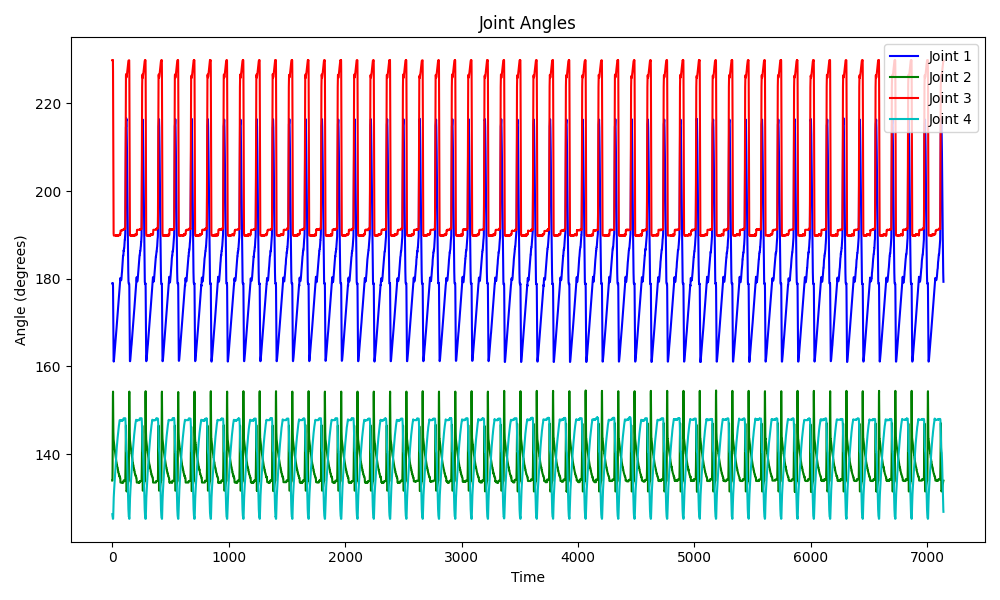

In [7]:
plot_joint_angles(Joint_pos)

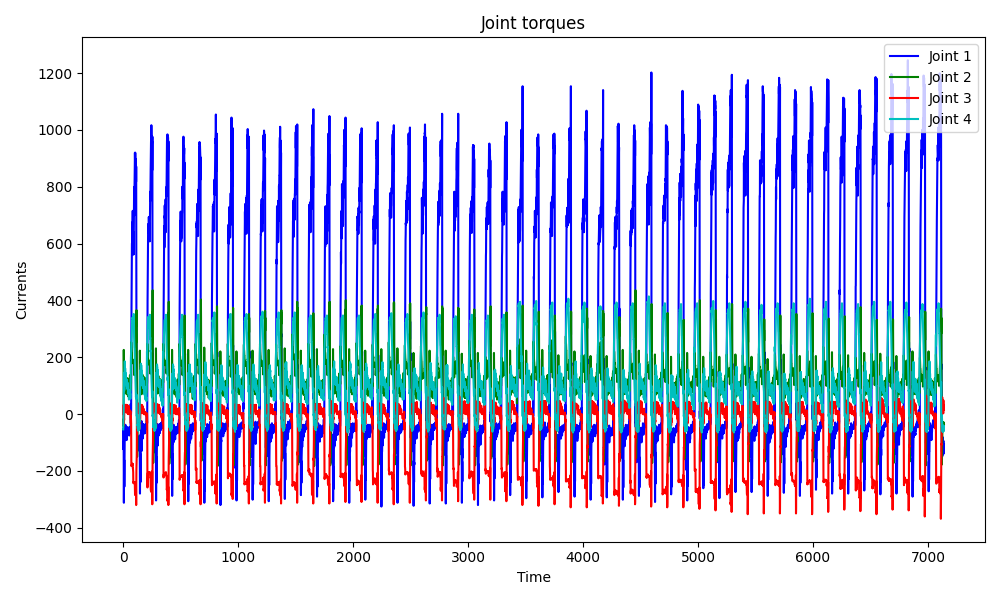

In [8]:
plot_joint_angles(Joint_tor, title="Joint torques", xlabel="Time", ylabel="Currents")

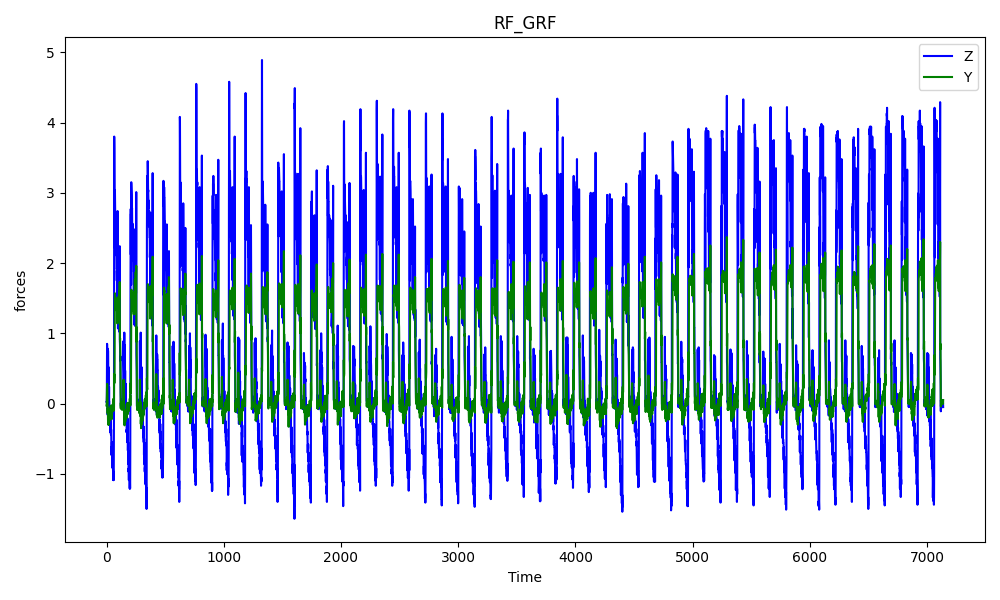

In [11]:
plot_foot_forces(RF_GRF, title="RF_GRF", xlabel="Time", ylabel="forces")

### Train the network for identify the Joint position (physical configuration of the limb)

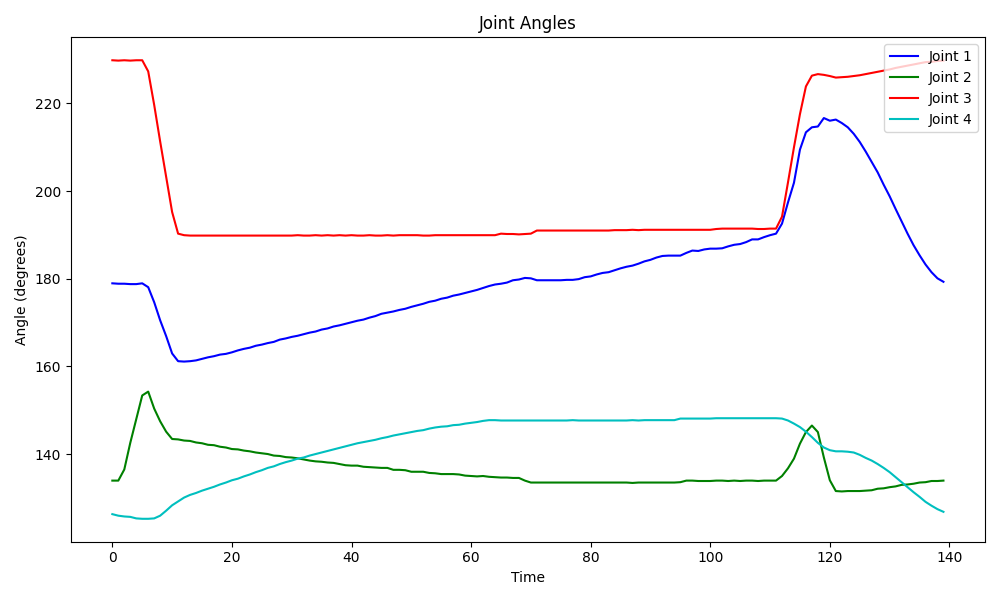

In [23]:
# 计算单个周期内关节角度值的唯一性
one_period_jp = Joint_pos[:1*period,:]
plt.close('all')
plot_joint_angles(one_period_jp, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)")

In [25]:
euclidean_distance(one_period_jp[0,:],one_period_jp[2,:])

np.float64(2.5962760913207643)

In [26]:
distance_for_config = np.zeros(period)
for i in range(period):
    distance_for_config[i] = euclidean_distance(one_period_jp[0,:],one_period_jp[i,:])

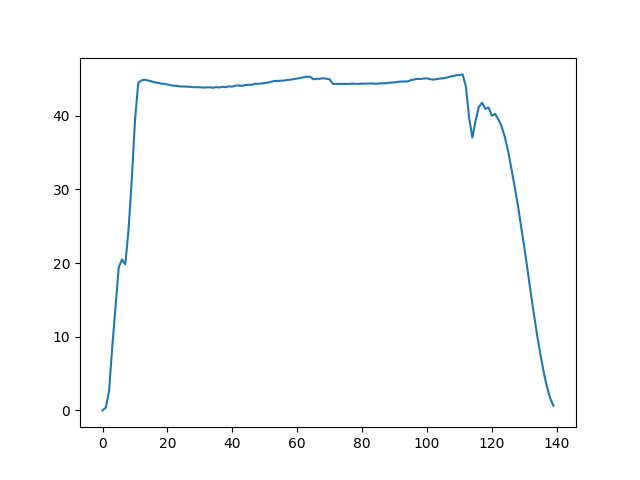

In [27]:
plt.close('all')
plt.plot(distance_for_config)

### build the simple ESN and understand its properties

#### Wash the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
# Create scaler and fit
scaler = MinMaxScaler(feature_range=(-1, 1))
Joint_tor_scaled = scaler.fit_transform(Joint_tor.reshape(-1,1)).reshape(-1,4)

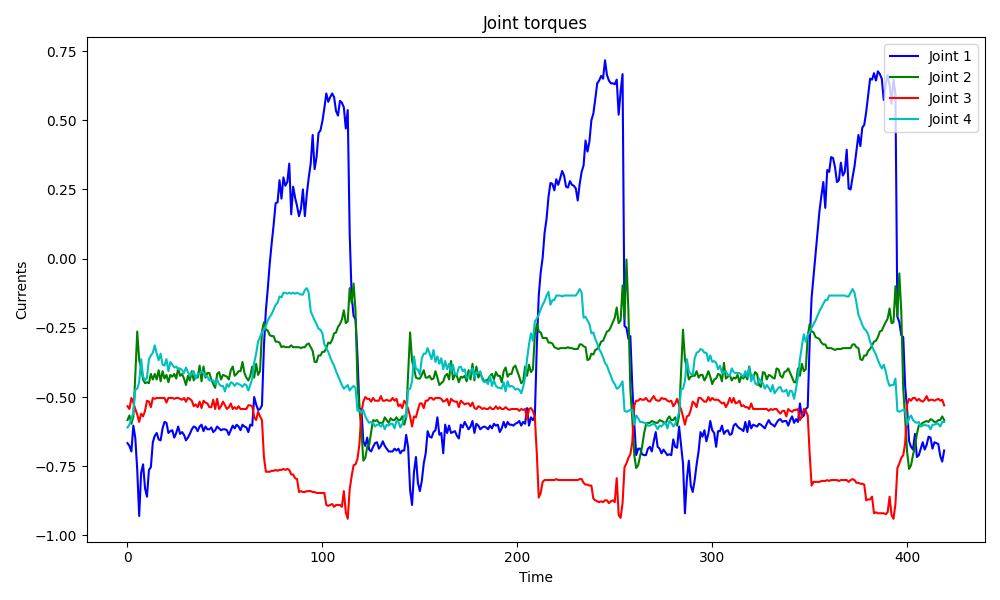

In [98]:
plt.close('all')
plot_joint_angles(Joint_tor_scaled[:period*3,:], title="Joint torques", xlabel="Time", ylabel="Currents")

In [116]:
esn_force_predict = ESN(4,100,2)

In [117]:
data_test = esn_force_predict.Win@Joint_tor_scaled[0,:]

In [118]:
import seaborn as sns

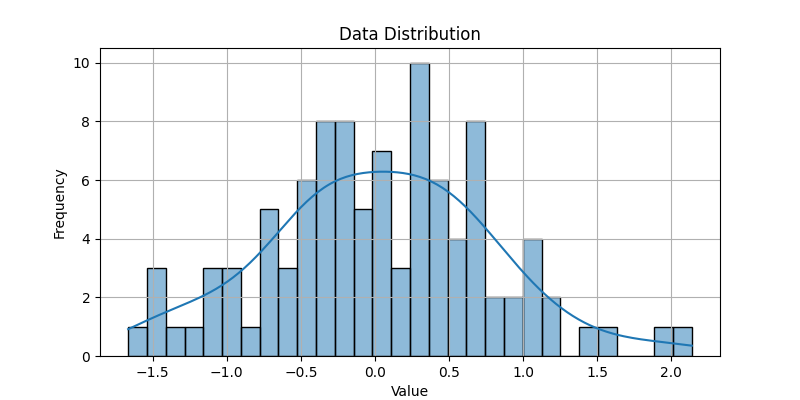

In [119]:
# visualize one data
plt.close('all')
plt.figure(figsize=(8, 4))
sns.histplot(data_test, bins=30, kde=True)
plt.title("Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [120]:
# store and build the states
states = []
for u in Joint_tor_scaled[:40*period,:]:
    state = esn_force_predict._update_state(u)
    states.append(state)

states = np.array(states)

In [121]:
np.linalg.matrix_rank(states)
time_line.shape

(100,)

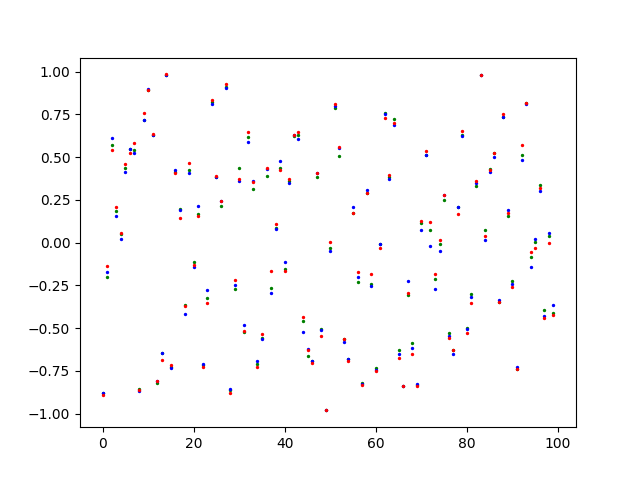

In [122]:
plt.close('all')
select_id = 70
time_line = np.arange(states[0,:].shape[0])
plt.scatter(time_line, states[select_id+0,:], color='g',s=2) 
plt.scatter(time_line, states[select_id+period,:], color='b',s=2) 
plt.scatter(time_line, states[select_id+20*period,:], color='r',s=2) 
# plt.plot(states[period,:],'g')
# plt.plot(states[20*period,:],'b')
plt.show()

#### Force perseve

In [125]:
select_id = 90
Joint_tor_scaled[select_id,:]

array([ 0.24999999, -0.31999999, -0.84333334, -0.12999999])

In [126]:
Joint_tor_scaled[select_id+10*period,:]

array([ 0.30333337, -0.30333333, -0.84666666, -0.12666665])

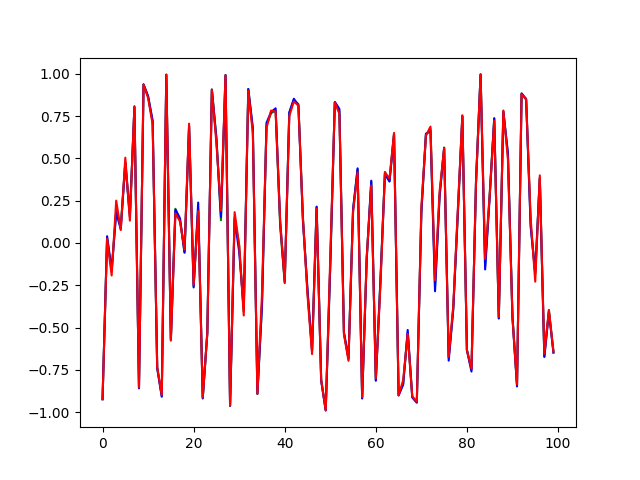

In [141]:
plt.close('all')
select_id = 125
time_line = np.arange(states[0,:].shape[0])
plt.plot(time_line, states[select_id+0,:], color='g') 
plt.plot(time_line, states[select_id+period,:], color='b') 
plt.plot(time_line, states[select_id+10*period,:], color='r') 

plt.show()

no vivid clues here

### Functions

In [115]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)

In [5]:
def euclidean_distance(point1, point2):
    """
    计算两个n维点之间的欧几里得距离
    
    参数:
        point1 (numpy.ndarray): 第一个点
        point2 (numpy.ndarray): 第二个点
        
    
    返回:
        float: 两点之间的欧几里得距离
    """
    return np.linalg.norm(point1 - point2)

In [6]:
def plot_joint_angles(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 4:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
    colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
    
    for i in range(4):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形

In [7]:
def plot_foot_forces(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 2:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Z', 'Y']
    colors = ['b', 'g']  # 不同颜色区分关节
    
    for i in range(2):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形